In [1]:
from typing import TypedDict, List, Dict, Any, Optional
from typing import Optional

class QAState(TypedDict):

    # The question that user asks
    question: str

    # The question type (reverse, logic)
    type: str
    
	# The extracted keywords
    keywords: Optional[str] = None

	# The context fetched from web
    context: Optional[str] = None

    # The final answer
    answer: Optional[str] = None

In [2]:
from langchain_community.llms import Ollama

llm = Ollama(model="qwen:14b", temperature=0)

C:\Users\user\AppData\Local\Temp\ipykernel_10768\2409861236.py:3: LangChainDeprecationWarning: The class `Ollama` was deprecated in LangChain 0.3.1 and will be removed in 1.0.0. An updated version of the class exists in the :class:`~langchain-ollama package and should be used instead. To use it run `pip install -U :class:`~langchain-ollama` and import as `from :class:`~langchain_ollama import OllamaLLM``.
  llm = Ollama(model="qwen:14b", temperature=0)


In [3]:
import getpass
import os

if not os.environ.get("TAVILY_API_KEY"):
    os.environ["TAVILY_API_KEY"] = getpass.getpass("Tavily API key:\n")

In [4]:
from tools import web_search

def read_question(state: QAState):
	print(f"Read question: \n{state['question']}")

	return {}

def answer_question(state: QAState):
    prompt = f"""
    Answer this question clearly and concisely. No explanation.

    Question: {state['question']}
    """
    response = llm.invoke(prompt)
    return {
        "answer": response
	}

def classify_question_type(state: QAState) -> QAState:
    prompt = f"""
	Read the following question carefully and classify it into exactly one of the following categories:

	- 'reverse': The question is written backwards or involves reading text in reverse.
	- 'logic': The question involves logical reasoning, abstract thinking, or puzzles (e.g., tables, sets, conditions).
	- 'web': The question asks about real-world entities (such as people, shows, dates, locations) that typically require external lookup or search.
	- 'others': The question is simple or doesn't fit the above types.

	Examples:

	Q: "If you write the word 'left' backwards, can you read this sentence?"
	A: reverse

	Q: "Given a set and an operation table, find counterexamples to commutativity."
	A: logic

	Q: "Who played the role of X in the Polish version of Y?"
	A: web

	Q: "How old is Alice?"
	A: others

	Important instructions:
	- Only answer with one lowercase word: reverse, logic, web, or others.
	- Avoid overthinking. If any real-world entity (person, media, place, date) is mentioned, it’s most likely 'web'.

	Now classify the following question:

	Question: {state['question']}
	"""

    response = llm.invoke(prompt).strip().lower()
    print(f"The type is likely to be '{response}'")
    return {
        "type": response
    }


def route_by_type(state: QAState) -> str:
    return state['type']

def reverse_sentence(state: QAState) -> QAState:
    return {
        "question": state['question'][::-1]
	}

def analyze_logic_node(state: dict):
    
	def extract_markdown_table(question: str) -> str:
		lines = question.strip().splitlines()
		table_lines = [line for line in lines if "|" in line]
		return "\n".join(table_lines)
    
	def parse_table_markdown(markdown_table: str) -> dict[tuple[str, str], str]:
		lines = markdown_table.strip().splitlines()
		headers = lines[0].split("|")[1:]  # skip first empty column
		table = {}
		for row in lines[2:]:  # skip header + --- line
			cells = row.split("|")[1:]
			row_label = cells[0].strip()
			for col_label, val in zip(headers[1:], cells[1:]):
				table[(row_label.strip(), col_label.strip())] = val.strip()
		return table
	
	def find_commutativity_violations(table: dict[tuple[str, str], str]) -> set[str]:
		elements = {a for a, _ in table.keys()}
		violating = set()
		for a in elements:
			for b in elements:
				if table[(a, b)] != table[(b, a)]:
					violating.update([a, b])
		return sorted(violating)

	table_md = extract_markdown_table(state["question"])
	parsed_table = parse_table_markdown(table_md)
	violating = find_commutativity_violations(parsed_table)

	return {
		"answer": ",".join(violating) if violating else "None"
	}

def search_web(state: dict) -> dict:
    question = state["question"]
    result = web_search(question) 
    #print(result)
    return {
        "context": result  
    }

def answer_with_context(state: QAState):
    context = state['context']
    question = state["question"]

    prompt = f"""
    You are given a question and an optional Wikipedia context. 
    If context is useful, base your answer on it. 
	If there's a date mentioned in the question, please make sure your answer is reasonable.
    
	Extract only the final answer to the original question, in the shortest possible form. 
    For example, if the question is "How many albums...", 
    only return the number (e.g., "3") without extra explanation.

    Context:
    {context}

    Question:
    {question}
    """

    response = llm.invoke(prompt)
    return {
		"answer": response
	}

def extract_keywords(state: QAState) -> QAState:
    prompt = f"""
	Extract the most important keywords from the following question for searching the wiki.
    Focus on named entities (people, titles, shows, events, country, language) or proper nouns and numbers relevant to identifying the correct answer.
	Preserve disambiguating information like nationality, language, or version (e.g., "Polish actor" or "Japanese version").
    Keep it short and relevant. Only a string that seperate the keywords by commas without any other sentences.
	Note that "Wikipedia" is not a keyword.

	Here provides an example.
	Question: Who played Naruto in the Japanese version of the anime?
	Answer: Naruto, Japanese version, anime

    Question: {state['question']}
    Keywords:
    """
    response = llm.invoke(prompt)
    print("Keywords: ", response)
    return {
		"keywords": response.strip() 
	}

def extract_final_answer(full_answer: str) -> str:
    prompt = f"""
    Here is an answer from an agent:
    ---
    {full_answer}
    ---
    Extract only the final answer to the original question, in the shortest possible form. 
    For example, if the question is "How many albums..." and the answer includes the list, 
    only return the number (e.g., "3") without extra explanation.

	For example,
	full_answer: "The capital of France is Paris." --> "Paris"
	full_answer: "The final answer is 50." --> "50"
	full_answer: "So there are 512 birds." --> "512"
    """
    response = llm.invoke(prompt).strip()
    return {
		"answer": response
	}

In [5]:
from langgraph.graph import StateGraph, START, END

builder = StateGraph(QAState)

# add nodes
builder.add_node("read", read_question)
builder.add_node("classify_type", classify_question_type)
builder.add_node("answering", answer_question)
builder.add_node("reverse", reverse_sentence)
builder.add_node("logic_table", analyze_logic_node)
builder.add_node("web", search_web)
builder.add_node("answer_with_context", answer_with_context)
builder.add_node("keyword", extract_keywords)
builder.add_node("final", extract_final_answer)

# edges
builder.add_edge(START, "read")
builder.add_edge("read", "classify_type")
builder.add_edge("reverse", "answering")
builder.add_edge("keyword", "web")
builder.add_edge("web", "answer_with_context")
builder.add_edge("answer_with_context", "final")
builder.add_edge("answering", END)
builder.add_edge("logic_table", END)
builder.add_edge("final", END)

# branching
builder.add_conditional_edges(
    "classify_type",
    route_by_type,
    {
        "reverse": "reverse",
        "logic": "logic_table",
        "web": "keyword",
        "others": "answering"
    }
)

# Compile graph
graph = builder.compile()

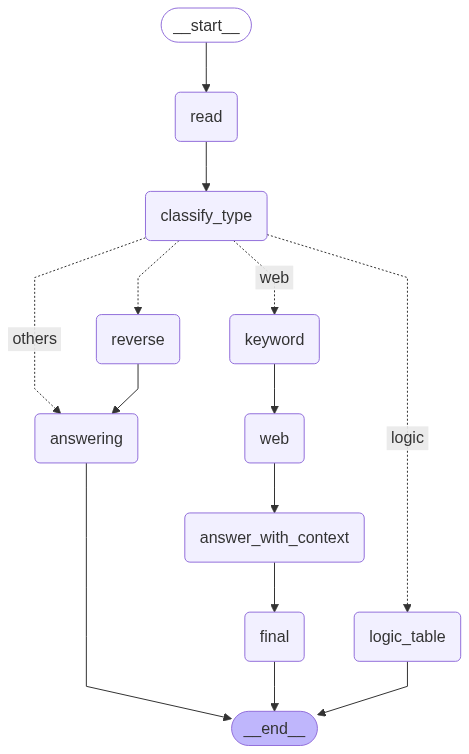

In [6]:
from IPython.display import Image, display

png_bytes = graph.get_graph().draw_mermaid_png()
with open("graph.png", "wb") as f:
    f.write(png_bytes)

display(Image(filename="graph.png"))

In [9]:
user_question = """
What is the surname of the equine veterinarian mentioned in 1.E Exercises from the chemistry materials licensed by Marisa Alviar-Agnew & Henry Agnew under the CK-12 license in LibreText's Introductory Chemistry materials as compiled 08/21/2023?
"""

In [10]:
state = graph.invoke({"question": user_question, "type": "others"})
print("Final Answer:", state['answer'])

Read question: 

What is the surname of the equine veterinarian mentioned in 1.E Exercises from the chemistry materials licensed by Marisa Alviar-Agnew & Henry Agnew under the CK-12 license in LibreText's Introductory Chemistry materials as compiled 08/21/2023?

The type is likely to be 'web'
Keywords:  equine veterinarian, 1.E Exercises, chemistry materials, Marisa Alviar-Agnew, Henry Agnew, CK-12 license, LibreText's Introductory Chemistry, 08/21/2023, surname
Final Answer: Louvrier
